# Marginal Votes for Electoral College Victory Notebook
This Jupyter Notebook is a product of Thomas Hymel, created on September 15th, 2020 in anticipation of the 2020 US Presidential Election, and updated later to include the 2020 election results.

I was inspired to create this notebook by some random headline statistic thrown out after the 2016 US election like ["The Election Came Down to 77,744 Votes in Pennsylvania, Wisconsin, and Michigan"](https://www.washingtonexaminer.com/weekly-standard/the-election-came-down-to-77-744-votes-in-pennsylvania-wisconsin-and-michigan-updated). Due to the Electoral College (EC) method of electing the US president, there can be a large discrepancy between Electoral College percentage win and total voting percentage win (or loss, in some elections). So in the 2016 election, Trump won the EC by only 77,744 votes across three states. If you define this metric as the main one to determine how "close" a US presidential election actually is, I was curious what this metric was for all other modern US elections. Unfortunately I couldn't find any article that detailed, calculated, or even mentioned any other election in the same way they did for 2016. 

So I thought I would calculate this metric for other US elections. I am going to officially call this metric the **"Marginal Votes for Electoral College Victory"** or **MVECV**. This is described as **the minimum number of popular votes needed to add to the Electoral College loser across all states such that the Electoral College loser becomes the Electoral College winner**. So, for example, if for some reason there was an extremely tight Electoral College race (51:49) but any given state was wildly partisan (90:10 votes for the state's victor) then the MVECV would still be pretty high, probably attributable to the lowest population state (because only 1 state would need to flip). Alternatively, in another imagined scenario, you could have a candidate win *every single US Electoral College vote*, which would be a "blowout" by EC standards, but the MVECV could be under 150 because that candidate could have won each EC contest by only a few popular votes.

The main raw data I need to calculate the MVECV is the following:
* For each election year:
    * For each state:
        * The EC votes granted to the winner
        * The popular vote tally for each candidate
        
From this information alone I can calculate things like:
* The EC winner of each state
* The number of votes needed for the next closest candidate to win each state
* The total number of EC votes each candidate received in each year
* The total number of EC votes needed to outright win the EC (and thus presidency)
* The MVECV of the next closest candidate

Because [voter turnout](https://en.wikipedia.org/wiki/Voter_turnout_in_the_United_States_presidential_elections) is no where *near* 100% in US presidential elections (~53% on average for the elections I will analyze), I will always assume that the votes needed to win would come from *additional* voters who didn't vote in that election, and not from voters switching their votes. For example, if there were a state with 100 votes to the winner Candidate A and 80 votes to the 2nd place Candidate B, you would have needed to convince 21 new people to vote for Candidate B for them to become the winner. However if you had convinced just 11 people of those Candidate A voters to switch to Candidate B, the final tally would instead be 89 for A and 91 for B. To frame this problem as a **"you should definitely vote"** kind of argument, I won't consider vote switching in the MVECV. I think it's more clean and compelling to say a statement like "If just 77,744 additional people across 3 states voted for Clinton, Trump would have lost."

Throughout this notebook, and mainly in the figures created, I will be referring to presidential election years by their years and their winners. The MVECV includes the word *victory* in it, so it may seem like, if I say Bush had an MVECV of 537 in 2000, I am implying that Bush lost and needed 537 more votes to win in 2000. I'm not. In referencing history, more people are familiar with presidential winners than the losers, so I chose to consistently use the winners and the election year. Additionally, because of our two-party system the MVECV metric applies to the election as a whole, not to any individual candidate anyway. 

## **Raw Data**
The raw data needed for this calculation is summarized as the following: for every election year and for every state in those election years I need the EC votes granted to the winner of that state and the popular vote tally for each candidate that was vying for that state.

The best *freely available* dataset that I could find that would be immediately applicable is the one provided by the [MIT Election Lab](https://electionlab.mit.edu/data), specifically [this link here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX). There are two problems with this dataset: 
1. it contains only the results from the elections of 1976 and onwards
2. it is notably **missing** the EC value for each state in each year. 

I can't rectify the first problem unless I use a different, pay-walled or academic-walled dataset (for example, [Dave Leip's Atlas of US Elections](https://uselectionatlas.org/) via [Princeton](https://libguides.princeton.edu/elections) or [Harvard](https://guides.library.harvard.edu/hks/campaigns_elections) login), so I'll just have to be satisfied with 1976 and onward (which honestly I am totally fine with). 

The second problem can be solved with a little bit of Excel work, combining it with the table found on the [US Electoral College](https://en.wikipedia.org/wiki/United_States_Electoral_College) Wikipedia page. This table has a full detailed history of each state's EC value in each presidential election year. From this table a new column was created in the .csv that properly assigned the EC value to each state. I'm going to assume the validity of both the MIT Election Lab dataset and the Wikipedia table. **Thank you to both of these sources!**

I'll be using pandas Dataframe to extract the information from the Excel spreadsheet that I made, and then pure python to calculate the MVECV for each year.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Personal Stuff/MVECV
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Personal Stuff/MVECV
'1976-2016-president new columns.xlsx'
 1976-2020-president.xlsx
 cb_2018_us_state_500k.cpg
 cb_2018_us_state_500k.dbf
 cb_2018_us_state_500k.prj
 cb_2018_us_state_500k.shp
 cb_2018_us_state_500k.shx
 final_MVECV.csv
 Marginal-Votes-for-Electoral-College-Victory-Notebook.ipynb


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mpltick

# filepath and the column names to be read into the Dataframe
xlsx_fp = '1976-2020-president.xlsx'
usecols_names = ['year', 'state', 'Electoral College', 'candidate', 'party_detailed', 'writein', 'candidatevotes', 'totalvotes']

# reading the xlsx file using pandas into a Dataframe
raw = pd.read_excel(io = xlsx_fp, sheet_name = '1976-2020-president', usecols=usecols_names)
raw = raw.rename(columns = {'party_detailed': 'party'})  # rename the party_detailed column to just party

# ensure the columns are as we expect and print the head of the df
print(raw.columns)
raw.head()

Index(['year', 'state', 'Electoral College', 'candidate', 'party', 'writein',
       'candidatevotes', 'totalvotes'],
      dtype='object')


,year,state,Electoral College,candidate,party,writein,candidatevotes,totalvotes
0,1976,ALABAMA,9,"CARTER, JIMMY",DEMOCRAT,0.0,659170,1182850
1,1976,ALABAMA,9,"FORD, GERALD",REPUBLICAN,0.0,504070,1182850
2,1976,ALABAMA,9,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,0.0,9198,1182850
3,1976,ALABAMA,9,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,0.0,6669,1182850
4,1976,ALABAMA,9,"HALL, GUS",COMMUNIST PARTY USE,0.0,1954,1182850


## **Some Light Clean Up**
Through my construction and importing of only specific columns, I have already purged some of the useless data that existed in the dataset. Furthermore, let's eliminate some other worthless data. **Normally this part of a dataset construction or collection process would be laborious**, but the sought-after data in our current example is straight forward, structured and pretty clean already.

So as an example, I'll eliminate the candidates that are NaN (or left blank in the original Excel file) and then show proof that they are gone. The candidates who had no names recorded were those who were written-in. After that, I'll just drop the 'writein' column because it's also worthless, and show that it has been dropped. 

In [42]:
# eliminate candidates that are NaN and show the results after
print(raw.isna().sum())
raw = raw.dropna(axis=0,  subset=['candidate'])
print(raw.isna().sum())

# get rid of writein column because we have no use for it, show proof that it is gone
print(raw.head())
raw.drop(columns=['writein'], inplace=True)
print(raw.head())


year                   0
state                  0
Electoral College      0
candidate            287
party                456
writein                3
candidatevotes         0
totalvotes             0
dtype: int64
year                   0
state                  0
Electoral College      0
candidate              0
party                246
writein                2
candidatevotes         0
totalvotes             0
dtype: int64
   year    state  Electoral College  ... writein candidatevotes  totalvotes
0  1976  ALABAMA                  9  ...     0.0         659170     1182850
1  1976  ALABAMA                  9  ...     0.0         504070     1182850
2  1976  ALABAMA                  9  ...     0.0           9198     1182850
3  1976  ALABAMA                  9  ...     0.0           6669     1182850
4  1976  ALABAMA                  9  ...     0.0           1954     1182850

[5 rows x 8 columns]
   year    state  ...  candidatevotes totalvotes
0  1976  ALABAMA  ...          659170    118285

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The 2020 version made all text data inside the table to be ALL CAPS LIKE THIS. I don't particularly enjoy reading all caps text, so I'll change that to normal text using the str.title() method of Python strings (well the Pandas equivalent implementation of it). 

In [43]:
for col in ['state', 'candidate', 'party']:    # only text columns we care about
    print(raw[col][0])   # before
    raw[col] = raw[col].str.title()
    print(raw[col][0])   # after

ALABAMA
Alabama
CARTER, JIMMY
Carter, Jimmy
DEMOCRAT
Democrat


## **Data Processing**

We now have a Dataframe with rows of voting results of each candidate, with the following column names:
* **year**  - the year of the election
* **state**  - the state that these results apply to
* **Electoral College** - the total number of Electoral College votes awarded to the winner by this state (same value for each year/state pair)
* **candidate** - the name of the candidate of this row
* **party** - the party of the candidate of this row
* **candidatevotes** - the number of votes the candidate of this row got in this state
* **totalvotes** - the total number of votes in this state in this year (same value for each candidate)

**I am going to make some assumptions to make it simpler to code.** For example, due to mature First Past the Post voting system the US currently has, the US population realistically has only two viable parties and candidates in each election, and as such always has one winner and one runner-up. Thus **Assumption 1** is that for any given state I only really care about the winner and the runner-up. Technically speaking the calculation for MVECV could be way more complicated if there were more viable parties, as one could imagine scenarios where the Electoral College votes of different states could be split multiple ways but the vote totals separating them are incredibly small.

**Assumption 2** is that all states give all their electoral college votes to the popular vote winner of that state. Now I know in reality this is not what actually happens, because a few states can technically split their electoral votes, but I don't have the data nor the desire to more accurately account for these few, small states. I feel this assumption is valid because those states that can split their votes are some EC value states. Although, arguably, if a state could more finely divide up its EC value then the vote differential to win those sub-ECs will tend to be smaller, and thus *potentially* more likely to be utilized in the final MVECV answer. Whatever, I'm sure it's fine. 

Here's some stuff to calculate initially. First, for each election calculate the total number of EC votes to win (rounded_up(total_EC/2)+1). Second, calculate the total number of EC votes received by either of the top two candidates. Third, calculate the vote differentials in each state between the winner and the loser of each state. Fourth, identify the loser candidate, and the states that were lost by that loser candidate. Fifth, calculate the EC differential, which is defined as the number of ECs needed to gain by the loser to win the election, not simply the difference between the winner's ECs and the loser's ECs. 

In [44]:
# in development we'll just handle one year, because we know the correct MVECV value for that year (~77K)
# and for ease of development
raw_2016 = raw[raw['year'] == 2016]
print(raw_2016.head())
US_states_list = list(raw['state'].unique())   # used for later calculations

      year    state  Electoral College  ...        party candidatevotes  totalvotes
3395  2016  Alabama                  9  ...   Republican        1318255     2123372
3396  2016  Alabama                  9  ...     Democrat         729547     2123372
3397  2016  Alabama                  9  ...  Libertarian          44467     2123372
3399  2016  Alabama                  9  ...        Green           9391     2123372
3400  2016   Alaska                  3  ...   Republican         163387      318608

[5 rows x 7 columns]


In [45]:
def create_election_dict(df):
    '''
    Create the election dictionary to help with other calculations
    
    Args:
        df [Dataframe]: pandas Dataframe object with certain columns needed to do the calculations
        
    Returns:
        dict: dictionary whose keys are election years and whose values are dictionaries. Those dictionaries contain
            keys that are all the states involved in that election year, and whose values are also dictionaries.
            Those dictionaries have keys that contain information about the winner, loser, vote differential, and ECs
            { year1 : { Alabama : {ec_worth: int, winner: Name1, loser: Name2, differential: (votes_for_1-votes_for_2)}, Georgia : {}}, year2: ...}
            Thus the typical usage of the election dictionary would be election_dict[year][state][info]
    '''
    
    election_dict = {}       # build up this dictionary to return
    
    for year in df['year'].unique():        # go through each election year in the dataframe
        this_year_df = df[df['year']==year] # grab a subset df of only the current election year
        this_year_dict = {}                 # build up this dictionary to use as the values for the election_dict var

        # go through each state in the current year and get all the necessary information
        for state in this_year_df['state'].unique():
            this_state_df = this_year_df[this_year_df['state']== state]   # grab a subset df of the only the current state 
            ec_worth = this_state_df['Electoral College'].unique()[0]   # grab the ec_worth. Should all be the same so we just take first index
            total_votes = this_state_df['totalvotes'].unique()[0]   # grab the total votes
            winner_df = this_state_df.loc[list(this_state_df['candidatevotes'].nlargest(n=2).index)[0]]  # gets the index of the candidate of the largest number in candidatevotes
            loser_df = this_state_df.loc[list(this_state_df['candidatevotes'].nlargest(n=2).index)[1]]   # gets the index of the candidate of the second largest number in candidatevotes
            winner, winner_party, winner_votes = winner_df['candidate'], winner_df['party'], winner_df['candidatevotes']
            loser, loser_party, loser_votes = loser_df['candidate'], loser_df['party'], loser_df['candidatevotes']
            differential = winner_votes-loser_votes
            this_year_dict[state] = {'ec_worth': ec_worth, 'total_votes': total_votes, 'differential' : differential,
                                     'winner' : winner, 'winner_party' : winner_party, 'winner_votes' : winner_votes,
                                     'loser' : loser, 'loser_party' : loser_party, 'loser_votes' : loser_votes
                                    }
        election_dict[year] = this_year_dict # assigning the constructed this_year's dictionary to the total election dictionary
            
    return election_dict

In [46]:
def create_summary_dict(election_dict):
    '''
    Creates a summary dictionary for each election year
    
    Args:
        election_dict [dict]: the output of create_election_dict
        
    Returns:
        dict: dictionary that contains years as keys, and the values are dictionaries. In those dictionaries (for each year)
            you have different summary statistics about that election. Like total_ec, ec_to_win, 
            candidates_ec which is a dictionary that holds the candidates as keys and their ECs won as values
            along with total_votes_cast, and other useful aggregate information
    '''
    
    summary_dict = {}
    for year in election_dict:
        total_ec = 0
        total_votes_cast = 0
        candidate_dict = {}
        for state in election_dict[year]:
            # get current state's EC and add to running total for summary dict
            states_ec = election_dict[year][state]['ec_worth']
            total_ec += states_ec

            # get total votes cast nation wide
            states_votes = election_dict[year][state]['total_votes']
            total_votes_cast += states_votes
        
            # add the current state's EC to the running tally of the candidates (winner only)
            winner = election_dict[year][state]['winner']
            if winner not in candidate_dict:
                candidate_dict[winner] = states_ec
            else:
                candidate_dict[winner] = candidate_dict[winner] + states_ec
        
        ec_to_win = int(total_ec/2 + 1)

        # identify winner and loser of the election (assumes there's a winner and loser, doesn't account for EC ties)
        winner_value = list(sorted(candidate_dict.values()))[-1] # gets the largest largest value
        loser_value = list(sorted(candidate_dict.values()))[-2] # gets the second largest value
        candidates_ec_won = candidate_dict.items()   # returns (key, value) pairs of the candidate dictionary
        for candi in candidates_ec_won:
            if candi[1] == loser_value:
                loser = candi[0]     # identified the loser
            if candi[1] == winner_value:
                winner = candi[0]     # identified the winner


        # calculate ec_differential (note that it's not winner_value - loser_value, but instead ec_to_win-loser_value)
        ec_differential = ec_to_win - loser_value

        # identify states lost by the loser
        states_lost = [state for state in election_dict[year] if election_dict[year][state]['winner'] != loser]

        # get party of election winner and loser
        election_loser_party = election_dict[year][states_lost[0]]['loser_party']
        election_winner_party = election_dict[year][states_lost[0]]['winner_party']
                
        # differential list: Of the states lost by the loser, records its differential votes to win, its EC value, and the name
        diff_list = []
        for state_lost in states_lost:
            combo = [election_dict[year][state_lost]['differential'], election_dict[year][state_lost]['ec_worth'], state_lost]
            diff_list.append(combo)
        
        summary_dict[year] = {'total_ec' : total_ec, 'ec_to_win' : ec_to_win, 'candidates_ec': candidate_dict, 
                              'winner' : winner, 'winner_party' : election_winner_party,
                              'loser' : loser, 'loser_party' : election_loser_party,
                              'states_lost' : states_lost, 'diff_list' : diff_list, 'ec_differential': ec_differential,
                              'total_votes_cast' : total_votes_cast,
                              }
        
    return summary_dict      

In [47]:
# test creation of the election dictionary
test_ed = create_election_dict(raw_2016)

# test creation of the summary dictionary
test_sd = create_summary_dict(test_ed)

for year in test_sd:
    print(f'The following is a summary of the election in {year}')
    for kvp in test_sd[year].items():
        print(kvp[0],':', kvp[1])

The following is a summary of the election in 2016
total_ec : 538
ec_to_win : 270
candidates_ec : {'Trump, Donald J.': 305, 'Clinton, Hillary': 233}
winner : Trump, Donald J.
winner_party : Republican
loser : Clinton, Hillary
loser_party : Democrat
states_lost : ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming']
diff_list : [[588708, 9, 'Alabama'], [46933, 3, 'Alaska'], [91234, 11, 'Arizona'], [304378, 6, 'Arkansas'], [112911, 29, 'Florida'], [211141, 16, 'Georgia'], [219290, 4, 'Idaho'], [524160, 11, 'Indiana'], [147314, 6, 'Iowa'], [244013, 6, 'Kansas'], [574117, 8, 'Kentucky'], [398484, 8, 'Louisiana'], [10704, 16, 'Michigan'], [215583, 6, 'Mississippi'], [523443, 10, 'Mis

## **Restatement of Problem and Implementing the Algorithm for Calculation**

So after a little bit of thinking about this problem I realized it is the **equivalent to the following problem**:

> Given a set of n ordered pairs (a,b) and a separate number X, where a,b,X are all positive integers, find the subset of those ordered pairs that have the smallest summation of a's while the summation of b's are greater than or equal to X. 

For our MVECV calculation here, the set of size n is the list of states lost; the ordered pairs (a,b) are (differential state votes, EC value); and X is the EC differential needed for the loser to win. Note that there is a very high chance that there is exactly one unique subset that is the MVECV. There are a bunch of subsets of states lost that could make the loser the winner if those states flipped, but we are searching for the *minimum* amount of marginal votes for that to happen. I want to implement an algorithm that we can be 100% sure that we will find the MVECV. 

My naive first attempt to implement a search algorithm was to simply create all the subsets of the set of states lost, then order them, and grab the first one whose summation of EC values was greater than the EC differential. Of course, when I said naive before, what I meant was *extremely* naive because creating the set of all subsets of a set is called the [powerset](https://en.wikipedia.org/wiki/Power_set), and the size of the powerset scales like 2^n where n is the size of the original set. As history turns out, the opponents of Reagan and George HW Bush in the 1980's lost **many** states, 40+ states. 2^40 = 1.1 trillion and 2^49 = 563 trillion. For computational purposes, this naive approach needs to be cut down significantly. 

After some tinkering and trial and error and testing of computational times, I landed on the final approach for my searching algorithm. I use recursion to construct combinations, or "combos", which are sums of the various lost states, and then check those combos as they are created to see if they are still a valid candidate for adding more to the combo. Additionally, I pass through the recursion function the current best combo. 

You can think of the set of combos as a tree, with the base node being one state in the list of states lost. Then, you combine that first state with all the other states, and recursively adding more states, creating branches and branches of combinations. After you finish exploring that entire starting node, you move onto the next state in the list, but do *not* include the previous base node in our list of states to combine with because we have already searched through all of those combinations. 

The algorithmic speed gains were actualized when I realized that there are two cases where you **don't** need to keep traversing down the current branch. 
* Case 1: Whenever a combo has a summation of EC values that is >= the EC differential, you may safely stop searching this branch. We know we can safely do this without "missing" the true MVECV (the absolute minimum sum of votes) because all vote differentials are positive numbers, as well as all EC values are positive numbers. So any state that you want to add to a combination that already satisfies the >= EC differential will *only increase* the summation of voter differentials. Because we are searching for the minimum of that summation, we may safely stop adding states to the current combination and check if it is better than the current best combo found. 
* Case 2: Because we are passing back through the recursion function the current best combo, whenever we combine a state with the current combo, we may immediately check if the voter differential summation is larger than the summation of the current best combo. If the summation *is* larger, it can't *possibly* be the MVECV, nor can any further branch created from that combination be the MVECV. Thus we stop searching that combo branch.

In [48]:
def find_MVECV_eff(sd, year, max_num_diff_list):
    '''
    More efficient implementation of the find MVECV algorithm (rather than brute force, basically)
    
    Args:
        sd [dict]: output from create_summary_dict
        year [int]: election year interested in 
        max_num_diff_list [int]: the maximum number of items in the differential state list that will be computed
        
    Return:
        list: MVECV in the form of [vote_total, sum_EC, state_names_in_one_string]
    '''
    
    # get ec_diff, loser and differential list from the summary dictionary
    ec_diff = sd[year]['ec_differential']
    loser = sd[year]['loser']
    diff_list = sd[year]['diff_list']
    diff_list = sorted(diff_list, key = lambda x : x[1], reverse = True)   # orders the diff_list by largest EC value to smallest EC value
    '''
    Note on the order of the diff_list: I attempted other orders, including all reasonable simple ones and more complex ones (dividing vote differential by EC value)
    but this order consistently showed the fastest performance for getting the correct answer on any of the non-trivial election years (ie, when calculations took 1 min+)
    '''
    
    if len(diff_list) < max_num_diff_list: max_num_diff_list = len(diff_list)
    print(f'In {year}, the list of states lost is {len(diff_list)}, and you chose to search through the first {max_num_diff_list}\n')
    diff_list = diff_list[:max_num_diff_list]    # slices the diff_list, grabbing only the first maximum number of diff_list
    
    # helper function to combine two combos
        # recall that each original combo = [vote_differential, EC_value, 'State_Name']
    def combine_combos(combo1, combo2):
        sum_diff = combo1[0] + combo2[0]    # creating the sum of vote differentials
        sum_EC = combo1[1] + combo2[1]      # creating the sum of EC votes
        if len(combo1[2]) == 0:             # passing the initial null string
            sum_state = combo2[2]
        else:                       
            sum_state = combo1[2] + ', ' + combo2[2]   # combining the states that consist of the sum
        combined = [sum_diff, sum_EC, sum_state]
        return combined

    # recursive function to compare in real time the best combo to the current combo
    def recurse_combo_best_guess(current_combo, list_of_combos, best_combo):
        if current_combo[1] >= ec_diff:           # if bigger, we check if it is better than the best combo
            if current_combo[0] < best_combo[0]:  # if better (lower total votes), we overwrite best_combo with current_combo. Regardless, we terminate this search path by returning the new (or previously) best combo
                best_combo = current_combo
        else:                                     # not bigger, we need to combine with next state, and recurse with the next set of lists
            for idx, combo in enumerate(list_of_combos):
                combined = combine_combos(current_combo, combo)
                if ',' not in combined[2]:                              # not computationally necessary, but good for me to know when the FIRST iteration of the recursive loop is moving to the next index
                    print(f'Starting a fresh combo tree with {combo}')
                if combined[0] < best_combo[0]:    # only if the newly combined combo has a chance of beating the best_combo, then we continue the search
                    best_combo = recurse_combo_best_guess(combined, list_of_combos[idx+1:], best_combo)
        return best_combo                          # regardless of which block of code we enter, whenever we exit we will always want to pass back the best_combo (whether that be the newly overwritten one or the old one)

    # best_combo recurse algorithm used
    best_starting = [10000000, 270, 'STARTING GUESS']    # we make the initial starting guess way too high to ensure we find something lower than it
    MVECV = recurse_combo_best_guess([0,0,''], diff_list, best_starting)
    
    return MVECV

In [49]:
def final_all_MVECVs(df, max_num_diff_list):
    '''
    Final function that finds all the MVECVs for each unique year in the Dataframe given to it
    
    Args:
        df [Dataframe]: the dataframe that contains all the columns necessary to create the election dictionary
        max_num_diff_list [int]: the maximum number of items in the differential state list that will be searched through
    
    Returns:
        dict: returns a dict with a bunch of information about the different years computed. See second to last line for dictionary information
    '''
    
    ed = create_election_dict(df)   # election_dict, containing all years in df
    sd = create_summary_dict(ed)    # summary_dict, containing all years in df
    print('Created election and summary dictionaries...\n')

    final_MVECV_data = {}
    for year in sd:
        MVECV = find_MVECV_eff(sd, year, max_num_diff_list)    # output is [votes, total_ec, states_names_concatenated]

        winner = sd[year]['winner']
        winner_ec = sd[year]['candidates_ec'][winner]
        winner_party = sd[year]['winner_party'].title()    # capitalize the winner_party
        winner = ' '.join(reversed(winner.split(', ')))    # making the name output look nicer

        loser = sd[year]['loser']
        loser_ec = sd[year]['candidates_ec'][loser]
        loser_party = sd[year]['loser_party'].title()     # capitalize the loser_party
        loser = ' '.join(reversed(loser.split(', ')))     # making the name output look nicer

        ec_differential = sd[year]['ec_differential']
        list_of_states = sd[year]['states_lost']

        nationwide_votes = sd[year]['total_votes_cast']

        # final print to screen output
        print(f'In {year}, {winner_party} {winner} with {winner_ec} ECs defeated {loser_party} {loser} with {loser_ec} ECs, an EC difference of {winner_ec-loser_ec}.')
        print(f'The MVECV was {MVECV[0]} votes across the states of {MVECV[2]}, worth a combined {MVECV[1]} ECs.')
        print(f'The popular vote total was {nationwide_votes}, and MVECV as a percentage of that is {100* MVECV[0]/nationwide_votes}% \n')

        final_MVECV_data[year] = { 'MVECV_votes' : MVECV[0], 'MVECV_ECs' : MVECV[1], 'MVECV_states' : MVECV[2], 
                                  'winner' : winner, 'loser' : loser, 'winner_ec' : winner_ec, 'loser_ec': loser_ec, 'winner_party' : winner_party, 'loser_party' : loser_party,
                                  'lost_states' : list_of_states, 'ec_diff' : ec_differential, 'nationwide_votes' : nationwide_votes}
        
    return final_MVECV_data

## Computing MVECV Year-by-Year

So even *after* I implemented the speed-ups **I still couldn't find the true MVECV for Reagan in 1984** without Google Colab disconnecting due to timing out. Thus I introduced the maximum number of states lost argument to the main algorithm function. In this way, I could tune how "long" a calculation would take, and still get *some* answer but *not* the true MVECV for 1984. Additionally, due to some tests where I changed the initial guess, I *know* that the true MVECV for 1984 Reagan is MORE than 2 million votes. I know this because I changed that to the initial best combo and it ran through the entire calculation and spit back out that 2 million votes was the best combo found. 

Furthermore, because of this limitation, I could not do the entire calculation in one single line using the cleaned-up raw Dataframe because it would always stall on 1984. :(. I had to settle for splitting it up year by year, or doing everything except 1984 and then 1984 separately. 

In [ ]:
# 1976
cur_year = 1976
%time mvecv_1976 = final_all_MVECVs(raw[raw['year']==cur_year], 24)

In [ ]:
# 1980
cur_year = 1980
%time mvecv_1980 = final_all_MVECVs(raw[raw['year']==cur_year], 43)

In [52]:
# 1984
cur_year = 1984
%time mvecv_1984 = final_all_MVECVs(raw[raw['year']==cur_year], 35)

Created election and summary dictionaries...

In 1984, the list of states lost is 49, and you chose to search through the first 35

Starting a fresh combo tree with [1544490, 47, 'California']
Starting a fresh combo tree with [375234, 36, 'New York']
Starting a fresh combo tree with [1484152, 29, 'Texas']
Starting a fresh combo tree with [356192, 25, 'Pennsylvania']
Starting a fresh combo tree with [620604, 24, 'Illinois']
Starting a fresh combo tree with [853119, 23, 'Ohio']
Starting a fresh combo tree with [1281534, 21, 'Florida']
Starting a fresh combo tree with [721933, 20, 'Michigan']
Starting a fresh combo tree with [672307, 16, 'New Jersey']
Starting a fresh combo tree with [71330, 13, 'Massachusetts']
Starting a fresh combo tree with [522194, 13, 'North Carolina']
Starting a fresh combo tree with [362094, 12, 'Georgia']
Starting a fresh combo tree with [535749, 12, 'Indiana']
Starting a fresh combo tree with [540828, 12, 'Virginia']
Starting a fresh combo tree with [425605, 11,

In [ ]:
# 1988
cur_year = 1988
%time mvecv_1988 = final_all_MVECVs(raw[raw['year']==cur_year], 40)

In [ ]:
# 1992
cur_year = 1992
%time mvecv_1992 = final_all_MVECVs(raw[raw['year']==cur_year], 33)

In [ ]:
# 1996
cur_year = 1996
%time mvecv_1996 = final_all_MVECVs(raw[raw['year']==cur_year], 32)

In [ ]:
# 2000
cur_year = 2000
%time mvecv_2000 = final_all_MVECVs(raw[raw['year']==cur_year], 30)

In [ ]:
# 2004
cur_year = 2004
%time mvecv_2004 = final_all_MVECVs(raw[raw['year']==cur_year], 31)

In [ ]:
# 2008
cur_year = 2008
%time mvecv_2008 = final_all_MVECVs(raw[raw['year']==cur_year], 29)

In [ ]:
# 2012
cur_year = 2012
%time mvecv_2012 = final_all_MVECVs(raw[raw['year']==cur_year], 27)

In [ ]:
# 2016
cur_year = 2016
%time mvecv_2016 = final_all_MVECVs(raw[raw['year']==cur_year], 30)

In [ ]:
# 2020
cur_year = 2020
%time mvecv_2020 = final_all_MVECVs(raw[raw['year']==cur_year], 26)

In [53]:
# all years not 1984, full search so MVECV will be found for all
%time mvecv_not1984 = final_all_MVECVs(raw[raw['year']!=1984], 50)

Created election and summary dictionaries...

In 1976, the list of states lost is 24, and you chose to search through the first 24

Starting a fresh combo tree with [418252, 41, 'New York']
Starting a fresh combo tree with [123073, 27, 'Pennsylvania']
Starting a fresh combo tree with [129019, 26, 'Texas']
Starting a fresh combo tree with [9333, 25, 'Ohio']
Starting a fresh combo tree with [166469, 17, 'Florida']
Starting a fresh combo tree with [399199, 14, 'Massachusetts']
Starting a fresh combo tree with [185405, 13, 'North Carolina']
Starting a fresh combo tree with [495666, 12, 'Georgia']
Starting a fresh combo tree with [70944, 12, 'Missouri']
Starting a fresh combo tree with [35245, 11, 'Wisconsin']
Starting a fresh combo tree with [73919, 10, 'Louisiana']
Starting a fresh combo tree with [86951, 10, 'Maryland']
Starting a fresh combo tree with [251045, 10, 'Minnesota']
Starting a fresh combo tree with [191910, 10, 'Tennessee']
Starting a fresh combo tree with [155100, 9, 'Alabam

In [57]:
# creating a combined MVECV dictionary with the probably-not-true-MVECV 1984 combination
mvecv_all_years = mvecv_not1984
mvecv_all_years.update(mvecv_1984)

In [58]:
# send it back to a Dataframe for ease of use
final_df = pd.DataFrame.from_dict(mvecv_all_years).T
final_df = final_df.sort_index()

# separate the MVECV_states that are in one string into a list of strings (should have done this before) and add a new column to df 
final_df['MVECV_states_separated'] = [combined_states.split(', ') for combined_states in list(final_df['MVECV_states'].values)]


print(final_df.to_markdown())

|      |      MVECV_votes |   MVECV_ECs | MVECV_states                                                                                                                                                                                           | winner             | loser            |   winner_ec |   loser_ec | winner_party   | loser_party   | lost_states                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   ec_diff |   nationwide_votes | MVECV_states

In [60]:
# export the final information dataframe to a csv file so we don't have to run any of the calculations again to access the summarized, final data
final_df.to_csv('final_MVECV.csv')  


# import the final information csv file whenever Google Colab kicks me off
#final_df = pd.read_csv('final_MVECV.csv',index_col=0 )

In [69]:
# manually changing the MVECV for 2020 due to tie-breaking mechanism, see explanation in Text-based Description in Analysis below

final_df.loc[2020]['MVECV_votes'] = 42918
final_df.loc[2020]['MVECV_ECs'] = 37
final_df.loc[2020]['MVECV_states'] = 'Georgia, Arizona, Wisconsin'
final_df.loc[2020]['MVECV_states_separated'] = ['Georgia', 'Arizona', 'Wisconsin']
final_df.loc[2020]

MVECV_votes                                                           42918
MVECV_ECs                                                                37
MVECV_states                                    Georgia, Arizona, Wisconsin
winner                                                   Joseph R. Jr Biden
loser                                                       Donald J. Trump
winner_ec                                                               306
loser_ec                                                                232
winner_party                                                       Democrat
loser_party                                                      Republican
lost_states               [Arizona, California, Colorado, Connecticut, D...
ec_diff                                                                  38
nationwide_votes                                                  158528503
MVECV_states_separated                        [Georgia, Arizona, Wisconsin]
Name: 2020, 

## **Analysis**

Now that I have found the MVECV (or at least a good approximation for 1984) for all the years that I have data available for, I want to give a summary and some light analysis on this metric. The **text-based summaries** that were printed out from the function are shown in the next collapsed section. You may expand it to read them. 

However data stories are meant to be told in **figures**. I have made three figures below, and will comment on them below.



### Text-Based Descriptions of the Elections and MVECVs
**Expand this section to see the text-based summaries.**

* In 1976, Democrat Jimmy Carter with 297 ECs defeated Republican Gerald Ford with 241 ECs, an EC difference of 56. **The MVECV was 16,705 votes** across the states of Ohio, Hawaii, worth a combined 29 ECs.
The popular vote total was 81601344, and MVECV as a percentage of that is 0.0204714765482294% 
* In 1980, Republican Ronald Reagan with 448 ECs defeated Democrat Jimmy Carter with 90 ECs, an EC difference of 358. **The MVECV was 1,293,273 votes** across the states of Pennsylvania, Illinois, Michigan, Massachusetts, North Carolina, Wisconsin, Louisiana, Tennessee, Alabama, Kentucky, South Carolina, Mississippi, Arkansas, Maine, Delaware, Vermont, worth a combined 181 ECs.
The popular vote total was 86496851, and MVECV as a percentage of that is 1.495167725816978% 
* In 1984, Republican Ronald Reagan with 525 ECs defeated Democrat Walter Mondale with 13 ECs, an EC difference of 512. **The MVECV was 5,755,810 votes** across the states of California, New York, Pennsylvania, Illinois, Michigan, Massachusetts, Georgia, Tennessee, Wisconsin, Maryland, Washington, Kentucky, Iowa, South Carolina, Oregon, West Virginia, worth a combined 257 ECs.
The popular vote total was 92654861, and MVECV as a percentage of that is 6.212097172106275% 
    * This MVECV answer was calculated with 34/49 lost states
* In 1988, Republican George H.W. Bush with 426 ECs defeated Democrat Michael Dukakis with 112 ECs, an EC difference of 314. **The MVECV was 1,075,509 votes** across the states of California, Pennsylvania, Illinois, Missouri, Maryland, Colorado, Connecticut, New Mexico, Maine, Montana, Delaware, North Dakota, South Dakota, Vermont, worth a combined 158 ECs.
The popular vote total was 91586825, and MVECV as a percentage of that is 1.174305365427833% 
* In 1992, Democrat Bill Clinton with 370 ECs defeated Republican George H.W. Bush with 168 ECs, an EC difference of 202. **The MVECV was 569,655 votes** across the states of Ohio, New Jersey, Georgia, Tennessee, Louisiana, Colorado, Kentucky, Hawaii, Nevada, New Hampshire, Delaware, Montana, worth a combined 103 ECs.
The popular vote total was 104599780, and MVECV as a percentage of that is 0.5446043959174676% 
* In 1996, Democrat Bill Clinton with 379 ECs defeated Republican Robert Dole with 159 ECs, an EC difference of 220. **The MVECV was 1,151,011** votes across the states of Florida, Ohio, Missouri, Tennessee, Arizona, Kentucky, Iowa, Oregon, New Mexico, Nevada, New Hampshire, worth a combined 111 ECs.
The popular vote total was 96389818, and MVECV as a percentage of that is 1.1941209392054253% 
* In 2000, Republican George W. Bush with 271 ECs defeated Democrat Al Gore with 267 ECs, an EC difference of 4. **The MVECV was 537 votes** across the states of Florida, worth a combined 25 ECs.
The popular vote total was 105593982, and MVECV as a percentage of that is 0.0005085517089411403% 
* In 2004, Republican George W. Bush with 286 ECs defeated Democrat John Kerry with 252 ECs, an EC difference of 34. **The MVECV was 115,570 votes** across the states of Colorado, Iowa, New Mexico, worth a combined 21 ECs.
The popular vote total was 122349450, and MVECV as a percentage of that is 0.09445894525884668% 
* In 2008, Democrat Barack H. Obama with 364 ECs defeated Republican John McCain with 174 ECs, an EC difference of 190. **The MVECV was 990,622 votes** across the states of Florida, Ohio, North Carolina, Virginia, Indiana, Iowa, New Hampshire, worth a combined 97 ECs.
The popular vote total was 131419253, and MVECV as a percentage of that is 0.7537875747931697% 
* In 2012, Democrat Barack H. Obama with 332 ECs defeated Republican Mitt Romney with 206 ECs, an EC difference of 126. **The MVECV was 429,464 votes** across the states of Florida, Ohio, Virginia, New Hampshire, worth a combined 64 ECs.
The popular vote total was 129139997, and MVECV as a percentage of that is 0.33255692270149273% 
* In 2016, Republican Donald J. Trump with 305 ECs defeated Democrat Hillary Clinton with 233 ECs, an EC difference of 72. **The MVECV was 77,744 votes** across the states of Pennsylvania, Michigan, Wisconsin, worth a combined 46 ECs.
The popular vote total was 136787187, and MVECV as a percentage of that is 0.056835732721077156%
* In 2020, Democrat Joseph R. Jr Biden with 306 ECs defeated Republican Donald J. Trump with 232 ECs, an EC difference of 74. **The MVECV was 76,514 votes** across the states of Georgia, Arizona, Wisconsin, Nevada, worth a combined 43 ECs.
The popular vote total was 158528503, and MVECV as a percentage of that is 0.04826513753176613%
    * Note that this isn't *technically* the correct MVECV, but the ability to get to the correct answer with the algorithm alone is out of the scope of this exercise. With only Georgia, Arizona, and Wisconsin flipping, the EC totals would have been 269-269, a dead tie. Consequently, the tie-breaking mechanism would have given Trump the win. 
    * Due to this, I will manually change the MVECV to 42,918 (the sum of those three states) for this year to reflect reality in a way my code could not. 

### Making Bar Graph Figures
This section focuses on creating bar graph figures for the MVECV information that has been computed. 

**Figure 1, Figure 1-alt**: the first figure is a graph that shows the MVECV for each election and the Electoral College victory in each election. The point of this figure is to display the relative EC victory margin with the MVECV. My main point of this notebook is that I believe the MVECV is a better metric to measure presidential election "closeness" than the EC is, so I was curious how the different EC victories match up to their MVECV. If EC victory margin is a good metric for "closeness" (at least as good as MVECV) then the MVECV and the EC victory margins should be consistently, relatively close to each other. That is, if EC victory margin goes up by some constant factor, say 1.5, then the MVECV should consistently go up by 1.5 as well. Of course we know this isn't actually the case, just by the way that EC values are awarded. 

I created two different graphs: Figure 1 and Figure 1-alt. **Figure 1** shows the full calculations as is, including the unknown-to-be-true MVECV of 1984 Reagan election. The EC victory margin and the large MVECV compared to other years compress the other data to a smaller region of the graph. Ultimately because Reagan *absolutely crushed* the 1984 presidential election, there is now a bunch of unnecessary white space on my MVECV graph. I don't like that white space. Thus Figure 1-alt was created. **Figure 1-alt** is nearly the same graph, with the exception that Reagan 1984 MVECV and EC victory margin are manually set to 0, so that it does not squish everything else, and with a note that Reagan actually crushed it. Color schemes are used to denote the usual mapping of the parties of the victors: Republican=red and Democratic=blue.

In [70]:
# pulling data from final_df and constructing other data to prep for graphing
years = list(final_df.index)
winners_party = list(final_df['winner_party'])
color_map = {'Republican': 'red', 'Democrat' : 'blue'}
colorEC_map = {'Republican' : (1,0,0,0.4), 'Democrat': (0,0,1,0.4)}  # color for EC is muted via an alpha transparency value
colors = [color_map[party] for party in winners_party]
colorsEC = [colorEC_map[party] for party in winners_party]
winners= [name.split(' ')[-1] for name in list(final_df['winner'])]  # last name only of the winners
MVECV = list(final_df['MVECV_votes'])
EC_margin = list(final_df['winner_ec'] - final_df['loser_ec'])
xlabels = [str(years[idx]) + '\n' + winners[idx] for idx in range(len(years))]    # creating labels that combine year and winner last name

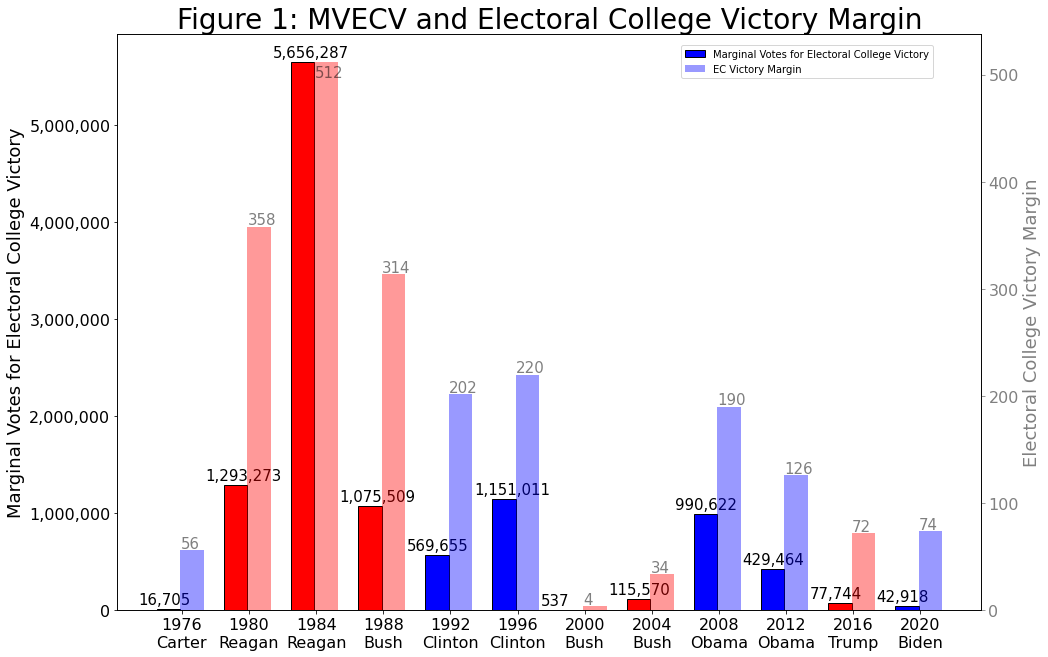

In [85]:
# graphing first figure with matplotlib
fig = plt.figure()
axm = fig.add_axes([0,0,2,2]) # creating the bounds of the figure, left y axis
width = 0.35  # the width of the bars
ind = np.arange(len(years))

axm.bar(x= ind, height= MVECV, width=width, color = colors, edgecolor = 'black')  # data for left y axis for MVECV
axe = axm.twinx()  # creation of right y axis for EC victory margin
axe.bar(x=ind+width, height = EC_margin, width=width, color = colorsEC) # data for right y axis on EC victory

# title, legend and x axis configs
axm.set_title(label = 'Figure 1: MVECV and Electoral College Victory Margin', fontsize=28)
fig.legend(labels = ('Marginal Votes for Electoral College Victory', 'EC Victory Margin'), loc= (0.65,0.88))
axm.set_xticks(ind+0.20)
axm.set_xticklabels(xlabels, fontsize=16)


#left y axis configs
axm.tick_params(axis='y', labelsize=16)
axm.set_ylabel('Marginal Votes for Electoral College Victory', fontsize = 18)
axm.ticklabel_format(axis='y', style = 'plain')
axm.get_yaxis().set_major_formatter(mpltick.FuncFormatter(lambda x, p: format(int(x), ',')))

# right y axis configs
axe.tick_params(axis='y', labelsize=16, colors='grey')
axe.set_ylabel('Electoral College Victory Margin', fontsize=18, color = 'grey')

# text application of values near the bars
for i,v in enumerate(winners):
    axm.text(x=i-0.45, y=MVECV[i]+50000, s= str("{:,}").format(MVECV[i]), fontsize=15, color = 'black')    # str("{:,}").format(number) displays a number with a comma separator
    EC_text_placement = EC_margin[i]+2
    # fixing the damn overlapping text manually
    if i == 2:       
        EC_text_placement -= 16
    axe.text(x = i+width-0.17, y=EC_text_placement, s = EC_margin[i], fontsize=15, color = (0,0,0,0.5))

fig.show()
fig.savefig('/content/gdrive/My Drive/Personal Stuff/MVECV/Figure1_2020.jpg', bbox_inches='tight')

In [72]:
# copy two of the necessary data that we need to change for alternative figure
import copy
MVECV_alt = copy.copy(MVECV)
EC_margin_alt = copy.copy(EC_margin)
MVECV_alt[2], EC_margin_alt[2] = 0,0

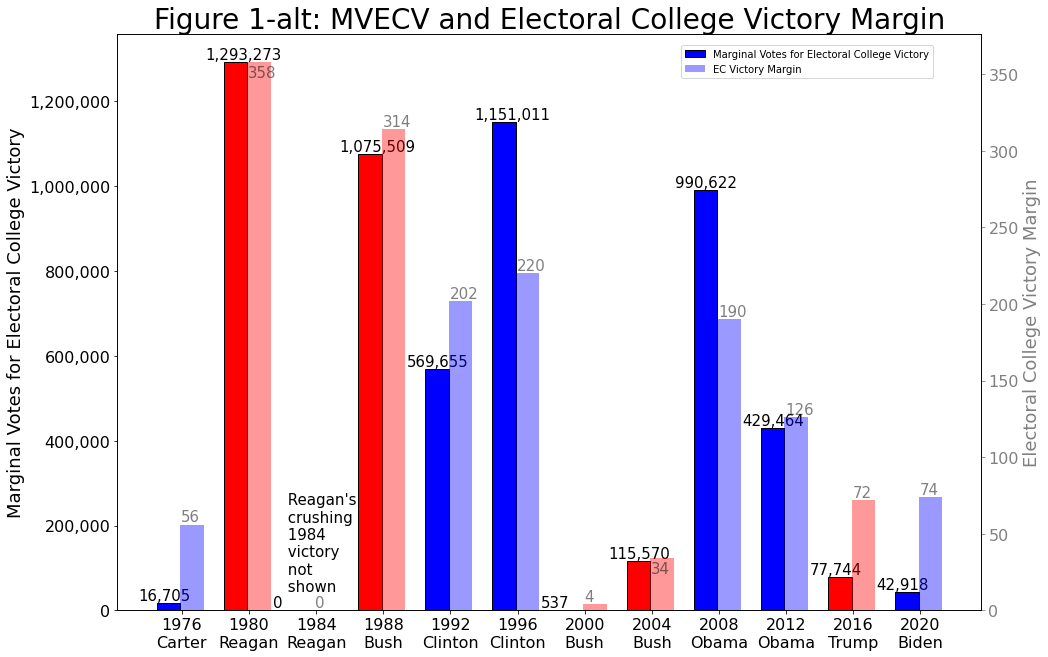

In [86]:

# graphing first figure with alternative with matplotlib
figa = plt.figure()
axma = figa.add_axes([0,0,2,2]) # creating the bounds of the figure, left y axis
width = 0.35  # the width of the bars
ind = np.arange(len(years))

axma.bar(x= ind, height= MVECV_alt, width=width, color = colors, edgecolor = 'black')  # data for left y axis for MVECV
axea = axma.twinx()  # creation of right y axis for EC victory margin
axea.bar(x=ind+width, height = EC_margin_alt, width=width, color = colorsEC) # data for right y axis on EC victory

# title, legend and x axis configs
axma.set_title(label = 'Figure 1-alt: MVECV and Electoral College Victory Margin', fontsize=28)
figa.legend(labels = ('Marginal Votes for Electoral College Victory', 'EC Victory Margin'), loc= (0.65,0.88))
axma.set_xticks(ind+0.20)
axma.set_xticklabels(xlabels, fontsize=16)

#left y axis configs
axma.tick_params(axis='y', labelsize=16)
axma.set_ylabel('Marginal Votes for Electoral College Victory', fontsize = 18)
axma.ticklabel_format(axis='y', style = 'plain')
axma.get_yaxis().set_major_formatter(mpltick.FuncFormatter(lambda x, p: format(int(x), ',')))

# right y axis configs
axea.tick_params(axis='y', labelsize=16, colors='grey')
axea.set_ylabel('Electoral College Victory Margin', fontsize=18, color = 'grey')


# text application of values near the bars
for i,v in enumerate(winners):
    axma.text(x=i-0.45, y=MVECV_alt[i]+7000, s= str("{:,}").format(MVECV_alt[i]), fontsize=15, color = 'black')    # str("{:,}").format(number) displays a number with a comma separator
    EC_text_placement = EC_margin_alt[i]+2
    # fixing the damn overlapping text manually
    if i == 1:   
        EC_text_placement -= 12
    if i == 7:
        EC_text_placement -= 12
    axea.text(x = i+width-0.16, y=EC_text_placement, s = EC_margin_alt[i], fontsize=15, color = (0,0,0,0.5))
axma.text(x = 2-0.3, y = 45000, s = ' Reagan\'s\n crushing\n 1984\n victory\n not\n shown', fontsize = 15)

figa.show()
figa.savefig('/content/gdrive/My Drive/Personal Stuff/MVECV/Figure1alt_2020.jpg', bbox_inches='tight')

**Figure 2**: Another figure I want to make is one that displays the frequency of the states that appear in the MVECV sets over the years. This statistic gives a good sense of which states are not only usually the closest in terms of absolute vote tally, but also in terms of the impact that state can make in the presidential election. Not unsurprisingly, the frequency roughly reflects the typical "swing-states" that campaigns and the media focus on leading up to an election.

In [74]:
from collections import Counter

final_df['MVECV_states_separated'] = [combined_states.split(', ') for combined_states in list(final_df['MVECV_states'])]

# creating a mapping from states' names to the frequency that they occur in MVECV sets
states_freq =  {state: 0 for state in US_states_list}
MVECV_all_states_dict = Counter([item2 for item in list(final_df['MVECV_states_separated']) for item2 in item])  # counts the instances of the states in all the MVECV sets to a dictionary
states_freq.update(MVECV_all_states_dict)
states_freq = dict(sorted(states_freq.items(),reverse=True))     # orders the dictionary alphabetically, to be plotted later
print(states_freq)

# all states have frequency of 0 initially in  a dictionary
states_freq_repub = {state: 0 for state in US_states_list}
states_freq_demo =  {state: 0 for state in US_states_list}

# creating a mapping from states' names to frequency based on the winner's party
MVECV_all_states_repub_winners_dict = Counter([item2 for item in list(final_df[final_df['winner_party'] == 'Republican']['MVECV_states_separated']) for item2 in item]) # slices only the years with a Republican winner
MVECV_all_states_demo_winners_dict = Counter([item2 for item in list(final_df[final_df['winner_party'] == 'Democrat']['MVECV_states_separated']) for item2 in item]) # slices only the years with a Democratic winner

# dictionaries get updated from their initial all zero state
states_freq_repub.update(MVECV_all_states_repub_winners_dict)
states_freq_demo.update(MVECV_all_states_demo_winners_dict)

# dictionaries get sorted
states_freq_repub = dict(sorted(states_freq_repub.items(),reverse=True)) 
states_freq_demo = dict(sorted(states_freq_demo.items(),reverse=True))


print(states_freq_repub)
print(states_freq_demo)

{'Wyoming': 0, 'Wisconsin': 4, 'West Virginia': 1, 'Washington': 1, 'Virginia': 2, 'Vermont': 2, 'Utah': 0, 'Texas': 0, 'Tennessee': 4, 'South Dakota': 1, 'South Carolina': 2, 'Rhode Island': 0, 'Pennsylvania': 4, 'Oregon': 2, 'Oklahoma': 0, 'Ohio': 5, 'North Dakota': 1, 'North Carolina': 2, 'New York': 1, 'New Mexico': 4, 'New Jersey': 1, 'New Hampshire': 4, 'Nevada': 2, 'Nebraska': 0, 'Montana': 2, 'Missouri': 2, 'Mississippi': 1, 'Minnesota': 0, 'Michigan': 2, 'Massachusetts': 2, 'Maryland': 2, 'Maine': 2, 'Louisiana': 2, 'Kentucky': 4, 'Kansas': 0, 'Iowa': 4, 'Indiana': 1, 'Illinois': 3, 'Idaho': 0, 'Hawaii': 2, 'Georgia': 3, 'Florida': 4, 'District Of Columbia': 0, 'Delaware': 3, 'Connecticut': 1, 'Colorado': 3, 'California': 2, 'Arkansas': 2, 'Arizona': 2, 'Alaska': 0, 'Alabama': 2}
{'Wyoming': 0, 'Wisconsin': 3, 'West Virginia': 1, 'Washington': 1, 'Virginia': 0, 'Vermont': 2, 'Utah': 0, 'Texas': 0, 'Tennessee': 2, 'South Dakota': 1, 'South Carolina': 2, 'Rhode Island': 0, 'Penn

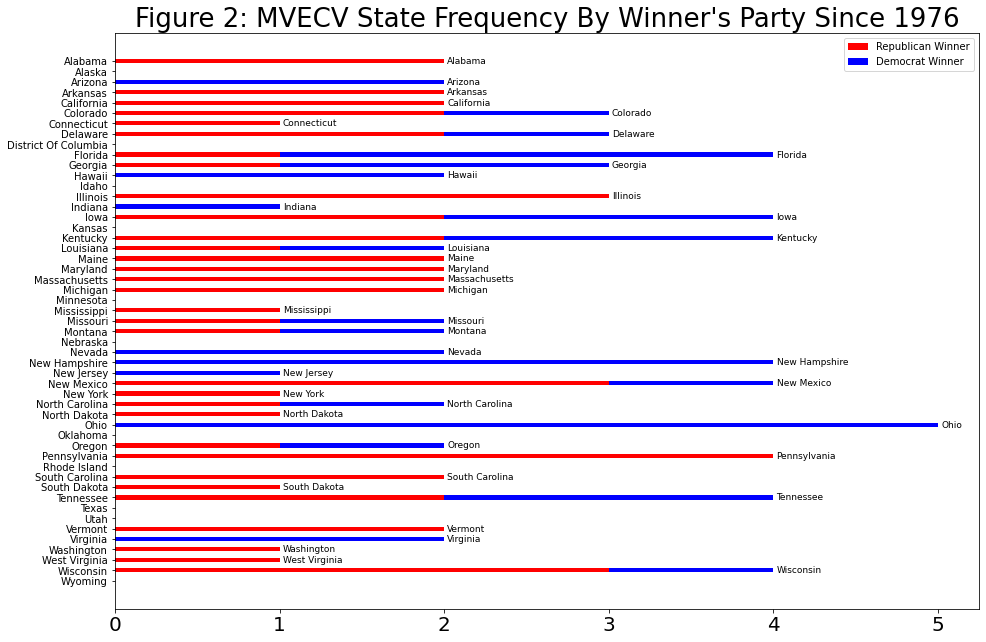

In [88]:
# graphing figure 2 with matplotlib
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,2,2]) # the x location for the years on the MVECV axis
width2 = 0.4  # the width of the bars
ind2 = np.arange(len(states_freq))

# title, legend and x axis configs
ax2.set_title(label = 'Figure 2: MVECV State Frequency By Winner\'s Party Since 1976', fontsize=26)
ax2.barh(y= list(states_freq_repub.keys()), height=width2, width= list(states_freq_repub.values()), color = color_map['Republican']) 
ax2.barh(y= list(states_freq_demo.keys()), height=width2, width = list(states_freq_demo.values()), left= list(states_freq_repub.values()), color = color_map['Democrat'] ) 
ax2.set_yticklabels(labels =states_freq_repub.keys(), fontsize=16, minor=True)
ax2.set_xticklabels(labels = ind2, fontsize=20)
ax2.legend(labels=['Republican Winner', 'Democrat Winner'])

# text application of values near the bars
for idx, key in enumerate(list(states_freq_repub.keys())):
    if states_freq_repub[key]+states_freq_demo[key] != 0:
        ax2.text(x=states_freq_repub[key]+states_freq_demo[key]+0.02, y=idx-0.25, s=key , fontsize=9, color = 'black')    # str("{:,}").format(number) displays a number with a comma separator

fig2.show()
fig2.savefig('/content/gdrive/My Drive/Personal Stuff/MVECV/Figure2_2020.jpg', bbox_inches='tight')

### Making a US Map Figure To Display MVECV State History
A better way to display US state-based data, especially as simple as mapping each state to a number, would be a US map. So I found out how to make a US state based figure in Python, and there's a handy package called geopandas that extends pandas into a GeoDataframe. You load a specific file (shapefile) in as a GeoDataframe, which contains the geometric information of the shapes that describe a map and it is able to plot maps with different attributes according to other values in that GeoDataFrame. The shapefile (.shp) that I used for the US map was downloaded from the United States Census Bureau [here.](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

I wanted to encode more information in this figure via characterizing not only how many times the different states appeared in an MVECV set, but also when those times were in elections in which Republicans won or in which Democrats won (like I did in Figure 2). I imagined doing this by coloring the states partially red or blue based on that information, but I'm not familiar enough to know if I can pull that off and I didn't feel like spending the time to figure out if it was possible (or to further code it if it is possible). 

I also wanted to show Hawaii and Alaska in an in-set but instead just put their results in text form because it was easier than coding a subplot and fiddling with all that stuff. 

In [76]:
# installing a package used to display US states maps
!pip install geopandas

     |████████████████████████████████| 1.0 MB 3.2 MB/s 
     |████████████████████████████████| 6.3 MB 42.9 MB/s 
     |████████████████████████████████| 15.4 MB 79 kB/s 


In [77]:
# import the package and read the shapefile 
import geopandas as gpd
US_map = gpd.read_file('cb_2018_us_state_500k.shp')


In [78]:
US_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [79]:
# remove the non-contiguous states in the GeoDataframe, and then change the projection to a different format
contig = US_map.loc[~US_map['NAME'].isin(['American Samoa', 'United States Virgin Islands', 'Guam', 'Commonwealth of the Northern Mariana Islands', 'Puerto Rico', 'Alaska', 'Hawaii'])]
contig = contig.to_crs('EPSG:3395')
print(contig.NAME)

0              Mississippi
1           North Carolina
2                 Oklahoma
3                 Virginia
4            West Virginia
5                Louisiana
6                 Michigan
7            Massachusetts
8                    Idaho
9                  Florida
10                Nebraska
11              Washington
12              New Mexico
14            South Dakota
15                   Texas
16              California
17                 Alabama
18                 Georgia
19            Pennsylvania
20                Missouri
21                Colorado
22                    Utah
23               Tennessee
24                 Wyoming
25                New York
26                  Kansas
28                  Nevada
29                Illinois
30                 Vermont
31                 Montana
32                    Iowa
33          South Carolina
34           New Hampshire
35                 Arizona
36    District of Columbia
39              New Jersey
40                Maryland
4

In [80]:
# adding in the states MVECV frequency as a column in the GeoDataframe
contig['MVECV'] = [0 for idx in range(len(contig.index))]
for kvp in states_freq.items():
    contig.loc[contig['NAME']==kvp[0], 'MVECV'] = kvp[1]   # assigning the MVECV column to the correct frequency
contig.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,MVECV
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-9852105.109 3509746.658, -985...",1
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-8429869.595 4266719.539, -842...",2
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-11466193.086 4347889.504, -11466151...",0
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-8431606.067 4526190.756, -843...",2
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-9199798.730 4576931.130, -9199776.3...",1


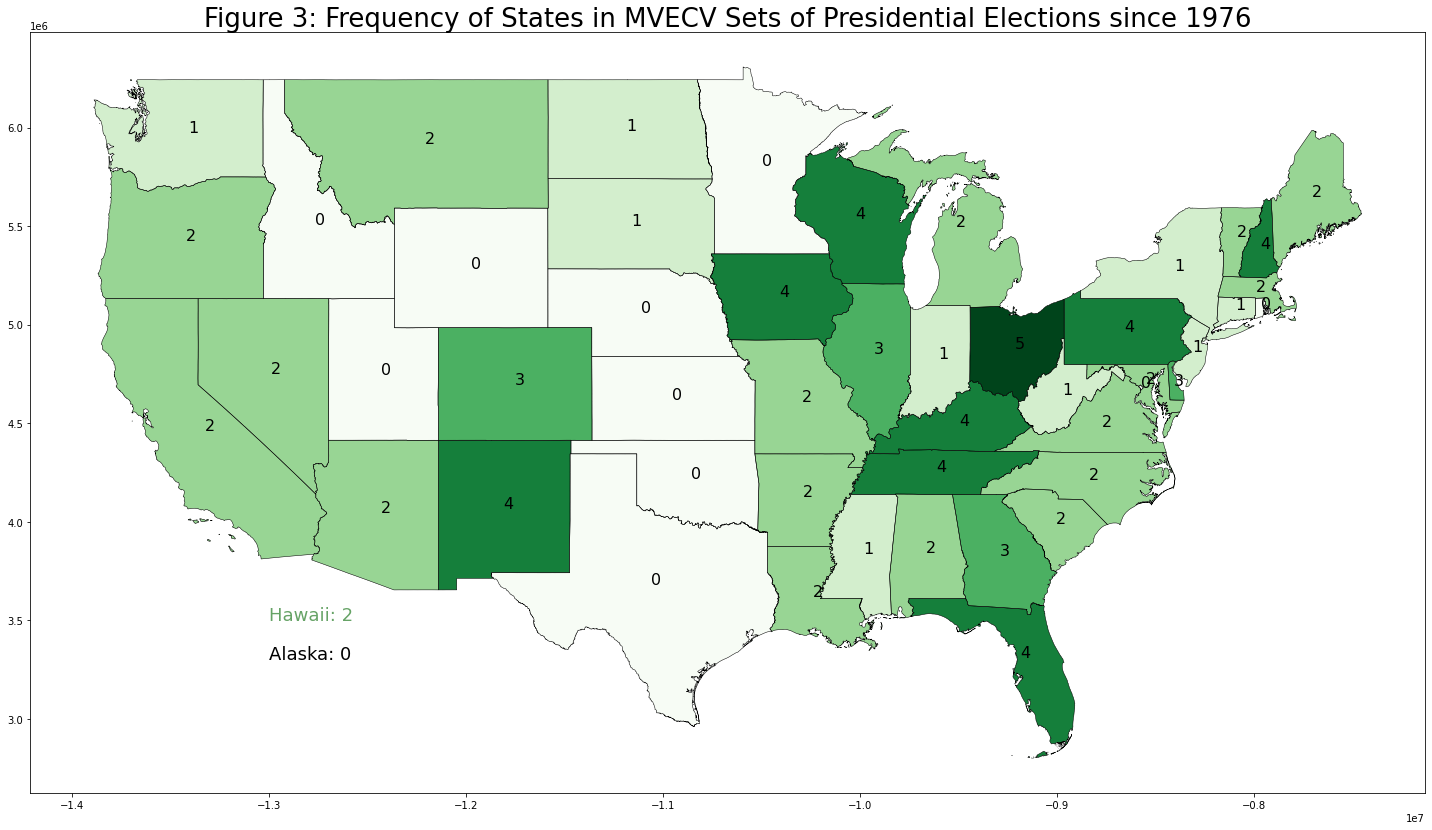

In [89]:
# creating the US Map figure
fig_map = plt.figure(1, figsize=(25,25))
ax_map = fig_map.add_subplot()
ax_map.set_title(label='Figure 3: Frequency of States in MVECV Sets of Presidential Elections since 1976', fontsize=26)
contig.boundary.plot(ax = ax_map, color='Black', linewidth=0.5)
contig.apply(lambda x: ax_map.annotate(s=str(x.MVECV), xy=x.geometry.centroid.coords[0], ha='left', fontsize=16, color='black'), axis=1 )
ax_map.annotate(s='Hawaii: ' + str(states_freq['Hawaii']), xy=(-13000000, 3500000), ha='left', fontsize=18, color= (0,0.4,0,0.6))   # add back in Hawaii manually
ax_map.annotate(s='Alaska: ' + str(0), xy=(-13000000, 3300000), ha='left', fontsize=18, color= 'black')   # add back in Alaska manually
contig.plot(ax = ax_map, column = 'MVECV', cmap = 'Greens', figsize=(14,14), legend=False) # colormap options found here: https://matplotlib.org/tutorials/colors/colormaps.html
fig_map.savefig('/content/gdrive/My Drive/Personal Stuff/MVECV/Figure3_2020.jpg', bbox_inches='tight')


## **Discussion**

**In Figure 1-alt**, the takeaway from the data can be found best when comparing two different elections to each other. For one example, let's take the 1992 Clinton win and the 1996 Clinton win. Based on the Electoral College victory margin of 202 and 220 respectively, Clinton won by a wide margin in both elections. One might suppose that, because these margins were so close to each other in magnitude, the MVECVs would also be close in magnitude. However, the 1996 Clinton MVECV **is more than twice** that of the 1992 Clinton MVECV. Clinton in 1996 was actually *way* more comfortable in his win than he was in 1992 than what the Electoral College would show. 

Take another example: 1988 HW Bush and 1996 Clinton. The EC margins are 314 and 220, respectively. Both won their elections with big margins, but actually Clinton won his election more securely because that election's MVECV was higher. 

Take another example: 2004 Bush and 2016 Trump. On EC margin of 34 to 72, Trump looked to have won his election with more leeway than Bush, who just barely squeaked by in *both* the elections he won. However the MVECV of Trump was 65% of Bush's! 2016 Trump's election was much closer than 2004 Bush's. 

Overall, from the data seen here, Republican presidents had been wildly popular from 1976 to 1988, where Democratic candidates just squeaked by or lost, and then a complete switch occurred. From 1992 to 2016, Republican presidents have either lost significantly (with MVECVs similar to those found by winning Republican presidents in 1976-1988) or just barely won with MVECVs much less than Democratic presidents in the same time frame. 

**In Figure 2**, the main lessons that can be learned are those that political campaign advisers and pundits already know. The swing states that ultimately "determine" the winner of the EC, and thus the election, coincide well with the MVECV states. I decided to color-code the frequency with the years in which those states showed up in MVECV sets. Note that this data includes the not-true MVECV for 1984 Reagan, and that there is more red-labeled data because the 1976-1988 Republicans won more states, and by a larger margin, than the later Democratic and Republican presidents. When an EC margin is large, it means that, more than likely, that election will be produce an MVECV set with more states because the summation of the states' ECs need to hit a larger number to be a valid set. 

There are a few interesting points to make though. For example, Ohio was found in the most MVECV sets, yet its bar is *entirely blue*. Whenever Ohio was found in an MVECV set, a Democratic candidate won that election. This fact seems to point to an important state to *absolutely win* for Democrats to win the overall election. Because Ohio was in the MVECV for Democratic candidates AND showed up for NONE of the Republicans winners, when Republicans win the overall election, then Ohio wasn't that close to affecting the EC result. The same is true for Michigan, Pennsylvania, and Wisconsin for Republicans (sounds familiar, eh?). All three of these states were found three times in MVECV sets, and every time they were found in elections in which Republicans won. 

There are 11 states (well, technically 10 states + Washington D.C.) that were *never* found in an MVECV set, regardless of the party of the winner. These states were never close enough, in either direction, to be worth their EC values in an MVECV set. Even if *any* of these states were as close as Florida in 2000, then it would almost certainly be included in the MVECV, even if they were worth only 3-5 ECs (because the ECs would be nearly "free" with respect to the voting summation). 



## **Conclusion**
The truth about the Electoral College is that, for the purposes of electing a president that governs all people living in all the states, it prioritizes a specific subset of Americans based on nothing more than geographical location within imaginary, boundary lines drawn by past people who had no idea about the potential future implications of those boundaries.

Furthermore, I did the calculation for MVECV as a potential argument to vote (for all those people who weren't planning on voting), because we do not know *ahead of time* which state will be in the MVECV set, or how low the MVECV actually will be. The MVECV of 77,744 votes in the 2016 Trump election was only 0.057% of *all* the votes cast in 2016. That's incredibly low! However it is clear that the marginal vote in those 10 states + Washington D.C. is, historically, almost worthless. 2020 has been a crazy year though, so perhaps this is the year one of those states will join all the others in being a part of an MVECV set. 

So, if you got all the way to this point, *and* if you haven't registered to vote yet, *and* if *this* Notebook provided the convincing push to register, *and* if you don't know where to go to register, then [here's a link](https://vote.gov/) to get your journey started. Have fun!